# Przetwarzanie tekstu i analiza opinii tweetów o platformach VOD

In [1]:
import snscrape.modules.twitter as sntwitter

import pandas as pd

import string

from tabulate import tabulate

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import numpy as np

Tworzymy bazy danych tweetów na temat HBO, Netflixa i Disney+. Robimy to za pomocą paczki snscrape używając funkcji sntwitter. Wybieramy 5000 tweetów opublikowanych przed 31.05.2022. Zapisujemy bazy do plików csv, aby przy następnych uruchomieniach prgogramu szybciej załadować dane.

In [2]:
# n = 5000

# hbo_list = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#hbo since:2021-01-01 until:2022-06-01 lang:en').get_items()):
#     if i>n:
#         break
#     hbo_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# hbo_df = pd.DataFrame(hbo_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# hbo_df.to_csv('hbo.csv', index = False)


# netflix_list = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#netflix since:2022-01-01 until:2022-06-01 lang:en').get_items()):
#     if i>n:
#         break
#     netflix_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# netflix_df = pd.DataFrame(netflix_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# netflix_df.to_csv('netflix.csv', index = False)


# disneyplus_list = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#disneyplus since:2021-01-01 until:2022-06-01 lang:en').get_items()):
#     if i>n:
#         break
#     disneyplus_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# disneyplus_df = pd.DataFrame(disneyplus_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# disneyplus_df.to_csv('disneyplus.csv', index = False)

Definiujemy funkcje, których będziemy używać dla każdej platformy.

 - tweet_to_bow tworzy zestaw słów (bag of words). Zmieniamy litery na małe, usuwamy cyfry, znaki interpunkcyjne i inne znaki specjalne, usuwamy także słowa zawierające nazwę platformy (np. dla HBO usuwamy słowa typu hbogo, hbomax). Dokonujemy tokenizacji tweeta, usuwamy stop words i dokonujemy lematyzacji
 - df_to_fdist tworzy słownik zliczeń wystąpień wszystkich słów dla podanej bazy danych wykluczając słowa zawierające nazwę platformy.
 - fdist_plot wyświetla wykres słupkowy liczby wystąpień słów dla podanego słownika 
 - pos_neg tworzy dwie listy zawierające opinie uznane za pozytywne lub negatywne dla podanej bazy danych
 - print_pos_neg wyświtla tabelę zawierającą liczbę i procent tweetów uznanych za pozytywne lub negatywne dla podanych list
 - pos_neg_fdist tworzy dwa słownik zliczeń wystąpień wszystkich słów dla podanej bazy danych wykluczając słowa zawierające nazwę platformy z podziałem na tweety uznane za pozytywne lub negatywne
 - wc_plot wyświetla chmurę tagów dla podanego słownika zliczeń
 - wc_plot2 wyświetla dwie chmury tagów dla podanych słowników zliczeń z podziałem na tweety uznane za pozytywne lub negatywne

In [3]:
def tweet_to_bow(platform, tweet): 
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', '’‘@#”“'))
    tweet = ''.join([i for i in tweet if not i.isdigit()])
    tweet = ' '.join([i for i in tweet.split() if platform not in i])
    tokenized=word_tokenize(tweet)
    
    stop_words=set(stopwords.words("english"))
    my_set = [platform, 'season', 'trailer', 'episode', 'series', 'show', 'teaser', 'tvshow', 'watch']
    stop_words.update(my_set)
    bag_of_words=[]
    for w in tokenized:
        if w.lower() not in stop_words:
            bag_of_words.append(w.lower())

    lemmatizer = WordNetLemmatizer()
    for i in range(len(bag_of_words)):
        bag_of_words[i] = lemmatizer.lemmatize(bag_of_words[i])
    
    return ' '.join(bag_of_words)


def df_to_fdist(df, platform):
    s = ''
    for index, row in df.iterrows():
        s = s + tweet_to_bow(platform, row[2])
    fdist = FreqDist(word_tokenize(s))
    return fdist


def fdist_plot(fd):
    D = dict(sorted(fd.items(), key=lambda item: item[1], reverse=True))
    l = (list(D.items())[:10])

    a = [item[0] for item in l]
    b = [item[1] for item in l]

    plt.figure(figsize=(14,6))
    plt.bar(a,b)
    plt.show()


def pos_neg(df):
    neg = []
    pos = []

    for index, row in df.iterrows():
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(row[2])
        if ss['compound'] < 0:
            neg.append(row[2])
        else:
            pos.append(row[2])
    return pos, neg
    
    
def print_pos_neg(pos, neg):    
    table = [['POSITIVE', len(pos), str(round(len(pos)/(len(neg)+len(pos))*100))+'%'],
            ['NEGATIVE', len(neg), str(round(len(neg)/(len(neg)+len(pos))*100))+'%']]
    
    print(tabulate(table, numalign="center", tablefmt="fancy_grid"))

    
def pos_neg_fdist(pos, neg, platform):
    neg_bow = ''
    for tweet in neg:
        neg_bow = neg_bow + tweet_to_bow(platform, tweet)

    pos_bow = ''
    for tweet in pos:
        pos_bow = pos_bow + tweet_to_bow(platform, tweet)

    neg_fdist = FreqDist(word_tokenize(neg_bow))
    pos_fdist = FreqDist(word_tokenize(pos_bow))
    
    return pos_fdist, neg_fdist


def wc_plot(fdist, platform, date):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=fdist)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('word cloud for tweets containing #'+platform+' '+date, fontdict={'fontsize': 30})
    plt.axis("off")
    plt.show()

    
def wc_plot2(fdist_pos, fdist_neg, platform, date):
    plt.figure(figsize=(20,15))

    plt.subplot(2, 1, 1)
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=fdist_pos)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('word cloud for negative tweets containing #'+platform+' '+date, fontdict={'fontsize': 25})
    plt.axis("off")

    plt.subplot(2, 1, 2)
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=fdist_neg)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('word cloud for positive tweets containing #'+platform+' '+date, fontdict={'fontsize': 25})
    plt.axis("off")

    plt.show()

# HBO

In [4]:
hbo = pd.read_csv('hbo.csv')
hbo

Datetime             Tweet Id  \
0     2022-05-31 23:45:49+00:00  1531784042907111426   
1     2022-05-31 23:41:00+00:00  1531782831353090050   
2     2022-05-31 23:22:59+00:00  1531778297868206080   
3     2022-05-31 23:19:26+00:00  1531777402422153217   
4     2022-05-31 23:06:53+00:00  1531774243150569472   
...                         ...                  ...   
4996  2022-04-08 09:48:09+00:00  1512366681426784258   
4997  2022-04-08 08:30:24+00:00  1512347115317510145   
4998  2022-04-08 06:26:06+00:00  1512315833942429698   
4999  2022-04-08 06:02:01+00:00  1512309770920898567   
5000  2022-04-08 05:52:40+00:00  1512307418461528065   

                                                   Text         Username  
0     @HBO Barry Season 3 episode 6 might be the bes...  kimberlycorby17  
1     #ScoobyDoo is making yet another comeback, thi...        gocollect  
2     This list of old #HBO shows not on #HBOMax is ...     jason_pettus  
3     raoul peck’s exterminate all the Brutus on #HB...   ProjectAllende  
4     The Time Traveler’s Wife…. He keeps going back...    CAMGIRL_movie  
...                                                 ...              ...  
4996  Good Morning Friends ☕️☕️☕️! Happy Friday! Hav...      WalksHippie  
4997  @hbomax why you release the #DeathOnTheNile mo...        FilolyFUT  
4998  @WhatSusanSays1 Do you know about #thenevers o...  excelsioricarus  
4999  Why is no one talking about how BADASS the cin...    TyChi_WiseGuy  
5000  The young ones on this app don’t know about be...       RankingsRs  

[5001 rows x 4 columns]

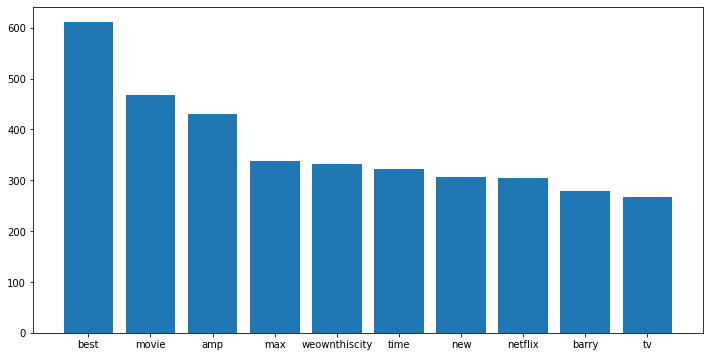

In [5]:
hbo_fdist = df_to_fdist(hbo, 'hbo')
fdist_plot(hbo_fdist)

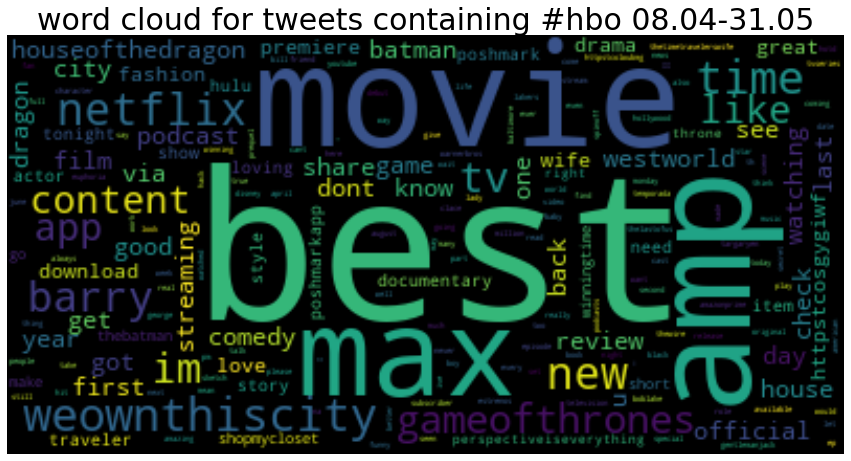

In [6]:
wc_plot(hbo_fdist, 'hbo', '08.04-31.05')

In [7]:
hbo_pos, hbo_neg = pos_neg(hbo)
print_pos_neg(hbo_pos, hbo_neg)

╒══════════╤══════╤═════╕
│ POSITIVE │ 4182 │ 84% │
├──────────┼──────┼─────┤
│ NEGATIVE │ 819  │ 16% │
╘══════════╧══════╧═════╛


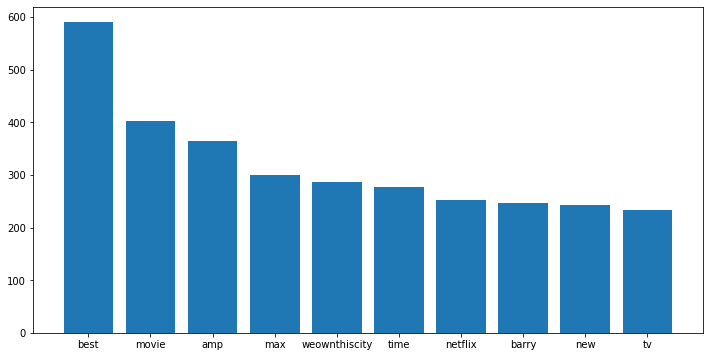

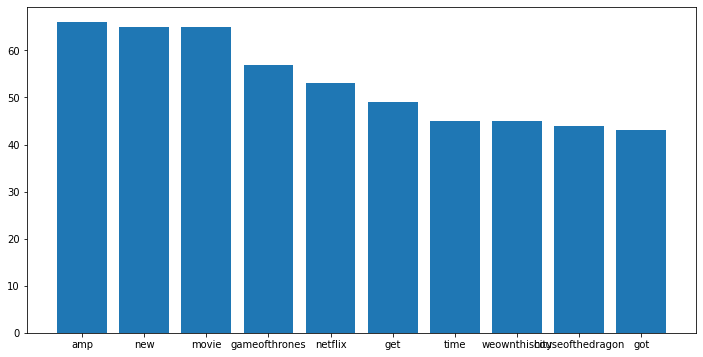

In [8]:
hbo_pos_fdist, hbo_neg_fdist = pos_neg_fdist(hbo_pos, hbo_neg, 'hbo')

fdist_plot(hbo_pos_fdist)
fdist_plot(hbo_neg_fdist)

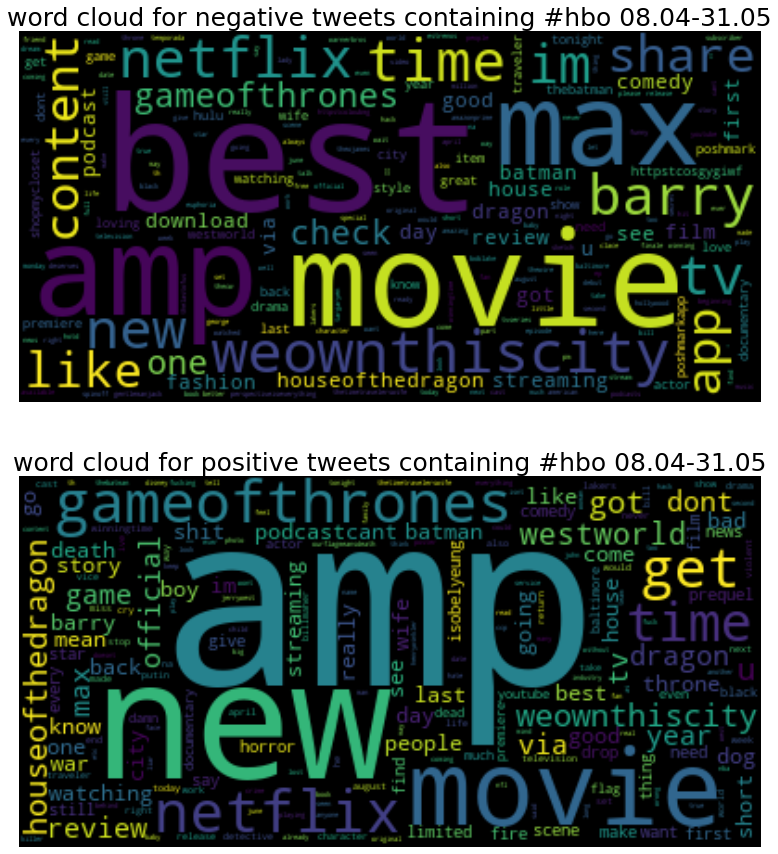

In [9]:
wc_plot2(hbo_pos_fdist, hbo_neg_fdist, 'hbo', '08.04-31.05')

# NETFLIX

In [10]:
netflix = pd.read_csv('netflix.csv')
netflix

Datetime             Tweet Id  \
0     2022-05-31 23:59:03+00:00  1531787371825463296   
1     2022-05-31 23:55:05+00:00  1531786372838592513   
2     2022-05-31 23:54:13+00:00  1531786156978880512   
3     2022-05-31 23:54:01+00:00  1531786104705372160   
4     2022-05-31 23:53:18+00:00  1531785927529578501   
...                         ...                  ...   
4996  2022-05-28 07:25:31+00:00  1530450177114484736   
4997  2022-05-28 07:24:59+00:00  1530450045757169664   
4998  2022-05-28 07:22:07+00:00  1530449323632345088   
4999  2022-05-28 07:21:46+00:00  1530449234930987008   
5000  2022-05-28 07:20:05+00:00  1530448811453124608   

                                                   Text         Username  
0     #StrangerThings4 was viewed at a whomping 286,...   wlbpodcastzero  
1     Netflix Camera Crew BANNED – FORBIDDEN To Cove...     TheOvertimer  
2     Man vs Bee looks lit!!! Cant wait🙏🏾 \n#netflix...    TeddyDa1Great  
3     #Netflix movie of the day: The Ballad of Buste...         flixboss  
4     @Stranger_Things #netflix #strangerthings seas...         Triad718  
...                                                 ...              ...  
4996  #StrangerThings #Netflix \n#StrangerThings4 \n...  AlbertS61447779  
4997  Someone please stop this plagiarism!!! #Strang...      LucaFalorni  
4998  Convention sur la série FATE : The Winx Saga A...     LinaNekolita  
4999  What in the American Horror Story is going on ...      pigflamingo  
5000  Why are all these 27 yrs old adults playing a ...    Cesar37958679  

[5001 rows x 4 columns]

27 maja miała miejsce premiera 4 sezonu Stranger Things.

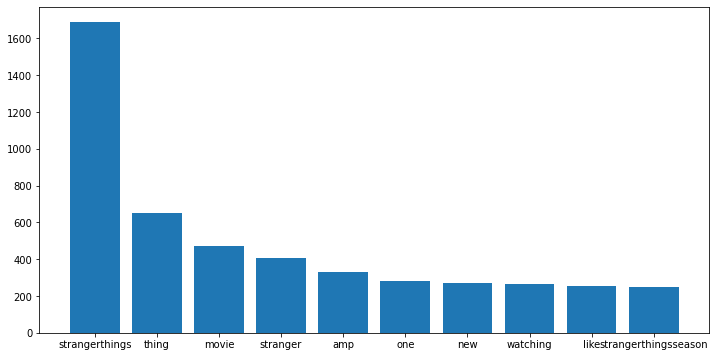

In [11]:
netflix_fdist = df_to_fdist(netflix, 'netflix')
fdist_plot(netflix_fdist)

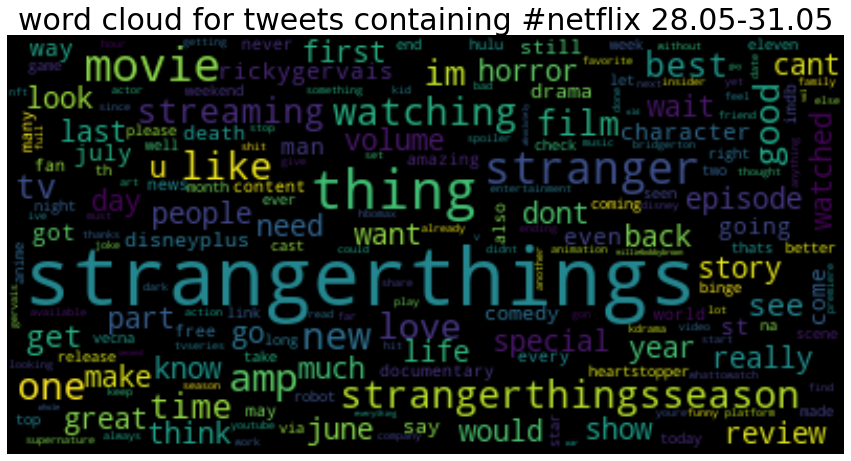

In [12]:
wc_plot(netflix_fdist, 'netflix', '28.05-31.05')

In [13]:
netflix_pos, netflix_neg = pos_neg(netflix)
print_pos_neg(netflix_pos, netflix_neg)

╒══════════╤══════╤═════╕
│ POSITIVE │ 3934 │ 79% │
├──────────┼──────┼─────┤
│ NEGATIVE │ 1067 │ 21% │
╘══════════╧══════╧═════╛


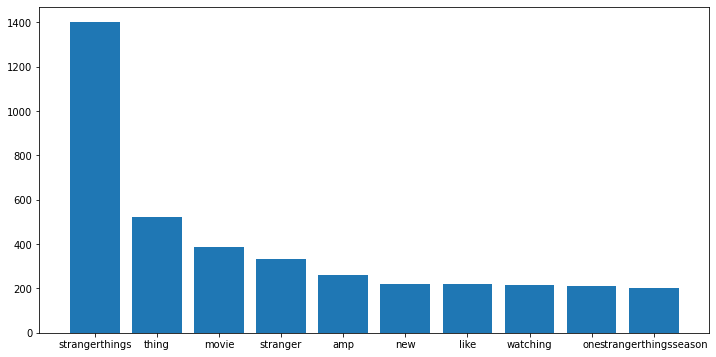

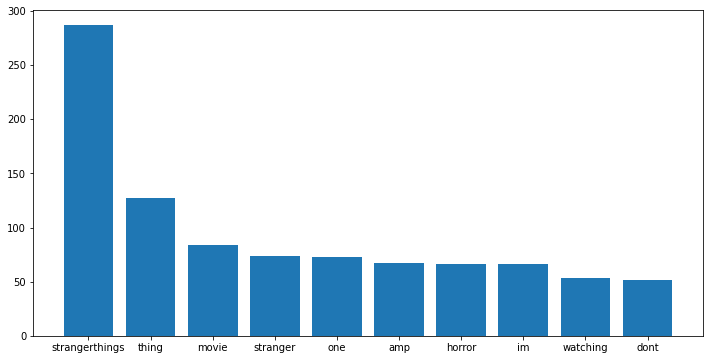

In [14]:
netflix_pos_fdist, netflix_neg_fdist = pos_neg_fdist(netflix_pos, netflix_neg, 'netflix')

fdist_plot(netflix_pos_fdist)
fdist_plot(netflix_neg_fdist)

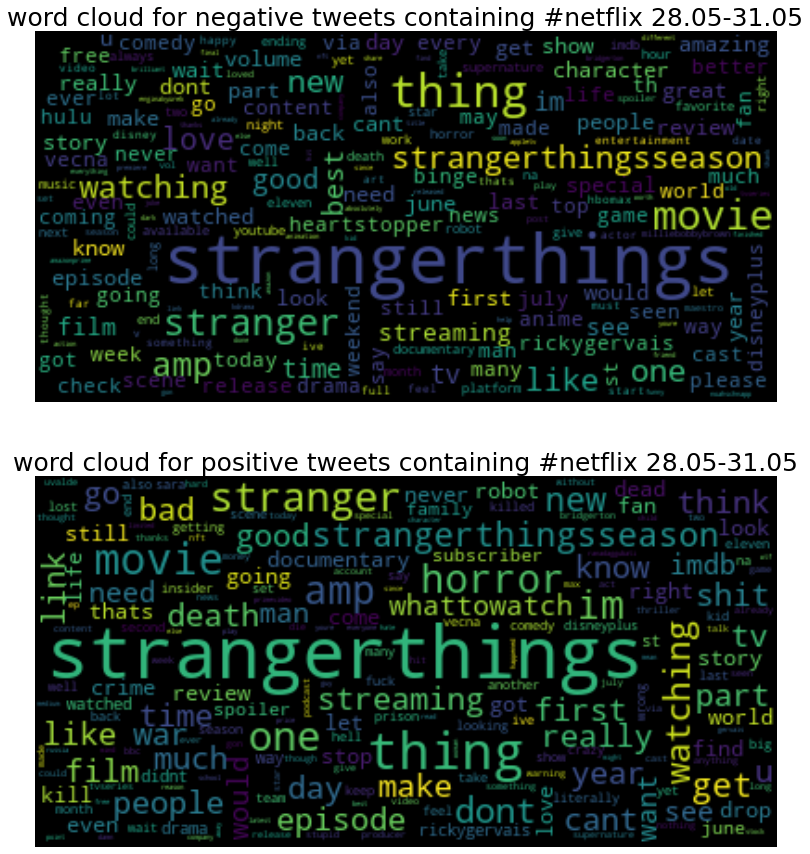

In [15]:
wc_plot2(netflix_pos_fdist, netflix_neg_fdist, 'netflix', '28.05-31.05')

14 stycznia Netflix ogłosił podniesienie cen, a także miała miejsce premiera finałowego sezonu Afterlife.

In [16]:
# netflix_list = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#netflix since:2022-01-14 until:2022-01-16 lang:en').get_items()):
#     if i>3000:
#         break
#     netflix_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# netflix_df = pd.DataFrame(netflix_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# netflix_df.to_csv('netflix2.csv', index = False)

In [17]:
netflix2 = pd.read_csv('netflix2.csv')
netflix2

Datetime             Tweet Id  \
0     2022-01-15 23:59:10+00:00  1482502653426888706   
1     2022-01-15 23:59:03+00:00  1482502621982121985   
2     2022-01-15 23:56:27+00:00  1482501966500708352   
3     2022-01-15 23:55:40+00:00  1482501769724895236   
4     2022-01-15 23:55:38+00:00  1482501760912703488   
...                         ...                  ...   
2881  2022-01-14 00:07:20+00:00  1481779931734544386   
2882  2022-01-14 00:07:18+00:00  1481779924461658113   
2883  2022-01-14 00:07:06+00:00  1481779872301465600   
2884  2022-01-14 00:05:49+00:00  1481779550585597959   
2885  2022-01-14 00:01:08+00:00  1481778372887736322   

                                                   Text         Username  
0     Check out The Stranger on Netflix very good ke...  ShesDionneBrown  
1     Squirt Game. I mean, Squirt Game. I mean, shoo...    gotfish2catch  
2     Love @AlbertoAmmann. He's so awesome as Pacho ...    SaritaJacques  
3     #gentefied\n@gentefied \nReal stories\nBeautif...     slimgirl5000  
4     Just finishing the first season of Longmire.Gr...      SteelKevlar  
...                                                 ...              ...  
2881  Asking #Netflix to put my babysitters a vampir...   emily_lngfrdft  
2882  Idk about this one #Netflix #AllOfUsAreDead\nh...  TheStoryMonster  
2883  🥊🥋🏅\nJust finished Kobra Kai season 3!\nNow to...     OzzyKangaroo  
2884  Well, this looks fucking awesome! \n\nAll of U...           Smeary  
2885  Netflix's Lost In Space Dethrones Marvel's Haw...  BerkleyBearNews  

[2886 rows x 4 columns]

In [18]:
netflix_pos2, netflix_neg2 = pos_neg(netflix2)
print_pos_neg(netflix_pos2, netflix_neg2)

╒══════════╤══════╤═════╕
│ POSITIVE │ 3934 │ 79% │
├──────────┼──────┼─────┤
│ NEGATIVE │ 1067 │ 21% │
╘══════════╧══════╧═════╛


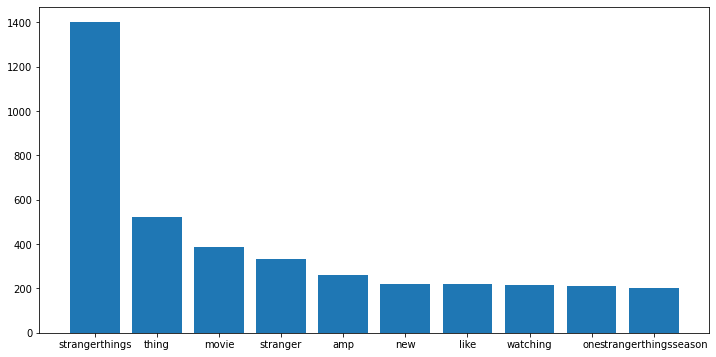

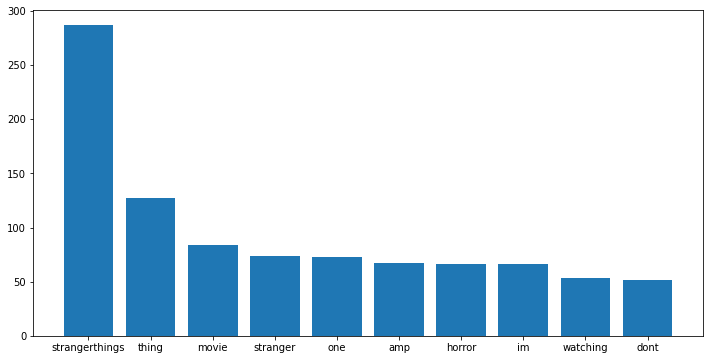

In [19]:
netflix_pos_fdist2, netflix_neg_fdist2 = pos_neg_fdist(netflix_pos2, netflix_neg2, 'netflix')

fdist_plot(netflix_pos_fdist2)
fdist_plot(netflix_neg_fdist2)

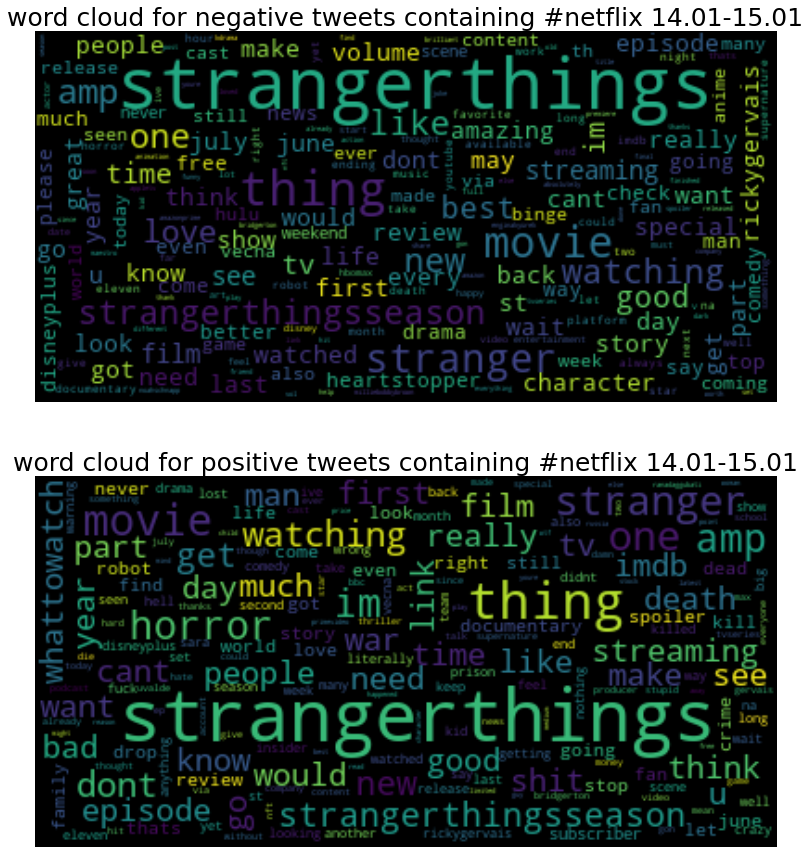

In [20]:
wc_plot2(netflix_pos_fdist, netflix_neg_fdist, 'netflix', '14.01-15.01')

# DISNEY+

In [21]:
disneyplus = pd.read_csv('disneyplus.csv')
disneyplus

Datetime             Tweet Id  \
0     2022-05-31 23:48:00+00:00  1531784590049873920   
1     2022-05-31 23:41:38+00:00  1531782991504150530   
2     2022-05-31 23:39:17+00:00  1531782398349692928   
3     2022-05-31 23:36:31+00:00  1531781702544130048   
4     2022-05-31 23:35:12+00:00  1531781371311534080   
...                         ...                  ...   
4996  2022-05-26 19:24:49+00:00  1529906421457997824   
4997  2022-05-26 19:24:42+00:00  1529906390952726530   
4998  2022-05-26 19:24:34+00:00  1529906356274225154   
4999  2022-05-26 19:23:30+00:00  1529906087473954818   
5000  2022-05-26 19:23:09+00:00  1529905999867432961   

                                                   Text         Username  
0     "Whoever causes one of these little ones who b...    RightyTeacher  
1     Prepping for Captain Marvel. And in IMAX forma...    traumahound03  
2     Is Disney in decline? #disneyplus subscriber n...        LtwWriter  
3     .@disneyplus Releases a New Trailer and Poster...  glittermagazine  
4     Wanted to take a moment today to say that #Mos...      BROODLORD75  
...                                                 ...              ...  
4996  Star Wars: Skeleton Crew, an Original series s...      ReggiesTake  
4997  #TheMandalorian Season 3 premieres 2023 only o...    DisneyBeat101  
4998  TRAILER REACTION: ANDOR\n\nVideo now live on Y...  GuyAtTheMovies1  
4999  Loved Rogue One, is one of my favourite Star W...     Rob_Watts_82  
5000  “Star Wars: The Mandalorian” Season 3 Disney+ ...   disneyplusnews  

[5001 rows x 4 columns]

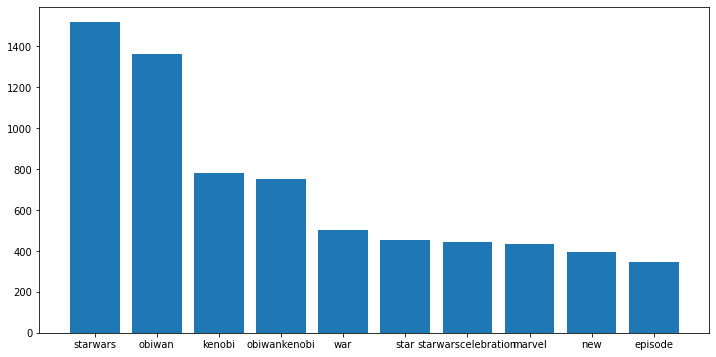

In [22]:
disney_fdist = df_to_fdist(disneyplus, 'disney')
fdist_plot(disney_fdist)

27 maja miała miejsce premiera pierwszego sezonu Star Wars: Obi-Wan Kenobi

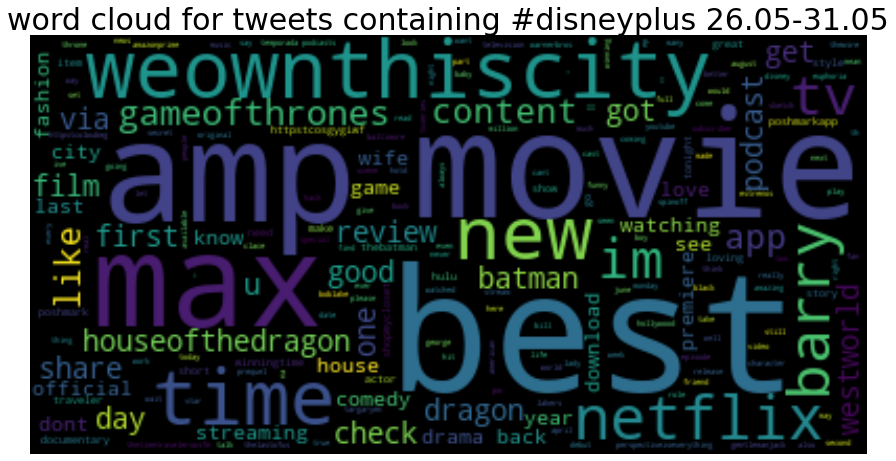

In [23]:
wc_plot(hbo_fdist, 'disneyplus', '26.05-31.05')

In [24]:
disney_pos, disney_neg = pos_neg(disneyplus)
print_pos_neg(disney_pos, disney_neg)

╒══════════╤══════╤═════╕
│ POSITIVE │ 3927 │ 79% │
├──────────┼──────┼─────┤
│ NEGATIVE │ 1074 │ 21% │
╘══════════╧══════╧═════╛


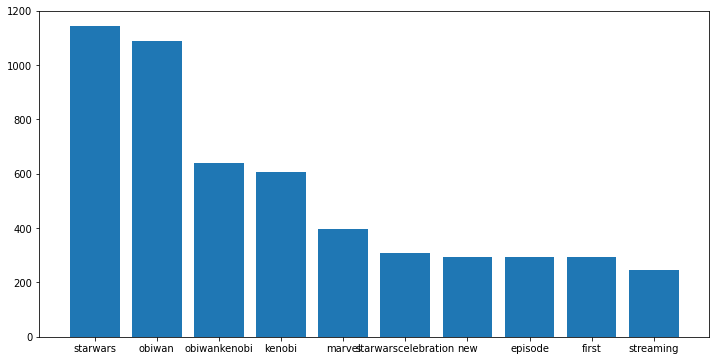

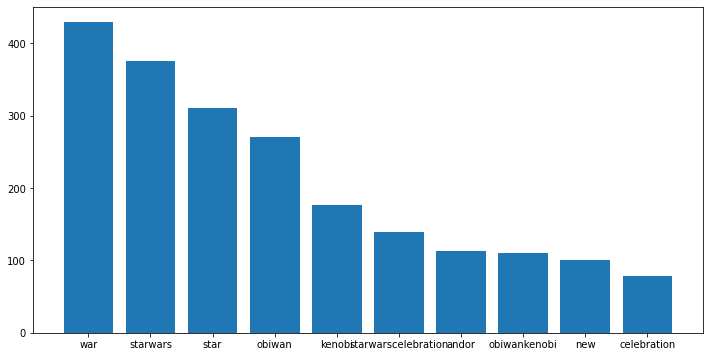

In [25]:
disney_pos_fdist, disney_neg_fdist = pos_neg_fdist(disney_pos, disney_neg, 'disney')

fdist_plot(disney_pos_fdist)
fdist_plot(disney_neg_fdist)

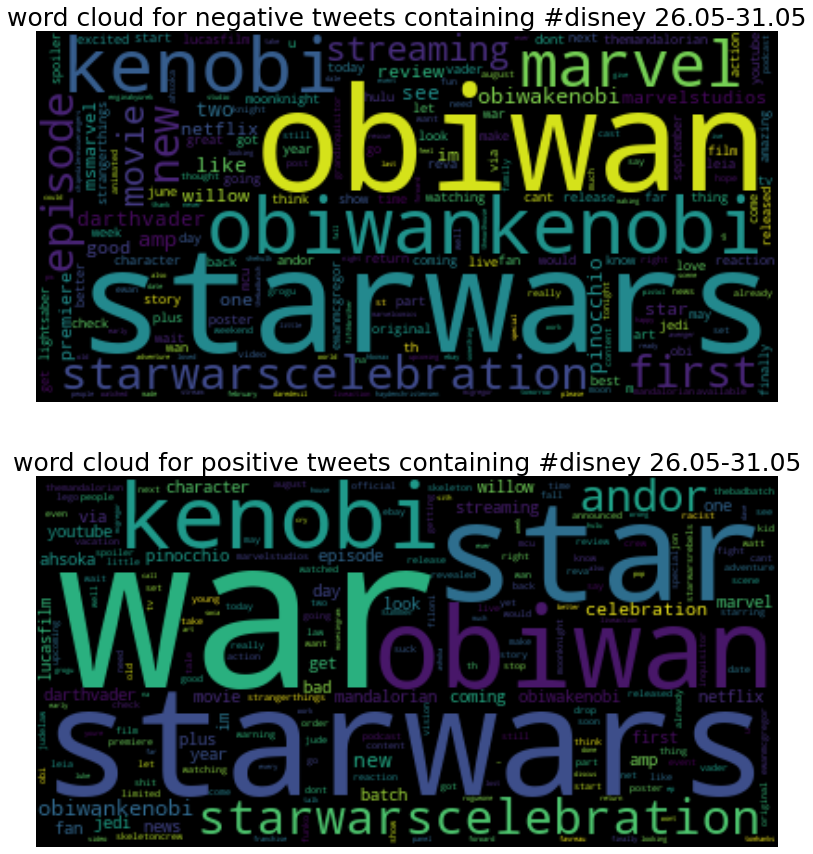

In [26]:
wc_plot2(disney_pos_fdist, disney_neg_fdist, 'disney', '26.05-31.05')

# HBO rozbite na kolejne tygodnie

In [27]:
# import time

# start = time.time()

# hbo_list = []

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#hbo since:2021-01-01 until:2022-01-01 lang:en').get_items()):
    
#     hbo_list.append([tweet.date, tweet.content])
    
# hbo_df = pd.DataFrame(hbo_list, columns=['Datetime', 'Text'])

# hbo_df.to_csv('hbo_year.csv', index = False)

# end = time.time()

# print(end-start)

In [28]:
hbo_year = pd.read_csv('hbo_year.csv')
hbo_year

Datetime  \
0      2021-12-31 23:29:35+00:00   
1      2021-12-31 23:21:03+00:00   
2      2021-12-31 22:43:39+00:00   
3      2021-12-31 22:01:01+00:00   
4      2021-12-31 21:56:21+00:00   
...                          ...   
33077  2021-01-01 02:48:30+00:00   
33078  2021-01-01 02:21:51+00:00   
33079  2021-01-01 01:48:28+00:00   
33080  2021-01-01 01:01:19+00:00   
33081  2021-01-01 00:49:51+00:00   

                                                    Text  
0      Watching @miracletbs ft #DanielRadcliffe &amp;...  
1      Start 2022 with a blast from the past! Harry P...  
2      #HBO #VICE 's Premeditated Lies — Uncut Interv...  
3      If you loved the #HBO #BandofBrothers podcast,...  
4      Watching @miracletbs #DarkAges ft #DanielRadcl...  
...                                                  ...  
33077  Fucl&lt;s so HarD....\n#GameOfThrones \n#hbo\n...  
33078  @FlightAttendant on @hbomax is one of the best...  
33079          I miss @CC_Sabathia #HBO #Yankees #legend  
33080  They were the men on TV. One of the greatest T...  
33081  HAPPY NEW YEAR‼️\n#YOSTA #HBC #HBO https://t.c...  

[33082 rows x 2 columns]

In [29]:
i = 0
b = True
stamp = datetime(2021, 12, 31)
hbo_year_neg = []
hbo_year_pos = []

while i < len(hbo_year):
    tweets_list = []
    while b and i < len(hbo_year):
        d = datetime(int(hbo_year.iloc[i]['Datetime'][:4]), int(hbo_year.iloc[i]['Datetime'][5:7]), 
                     int(hbo_year.iloc[i]['Datetime'][8:10]))
        if (stamp - timedelta(days=7)) >= d:
            stamp = d
            b = False
        else:
            tweets_list.append(hbo_year.iloc[i]['Text'])
            i = i + 1
    
    hbo_year_neg.append(0)
    hbo_year_pos.append(0)

    for tweet in tweets_list:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(tweet)
        if ss['compound'] < 0:
            hbo_year_neg[-1] = hbo_year_neg[-1] + 1
        else:
            hbo_year_pos[-1] = hbo_year_pos[-1] + 1
    b = True

In [30]:
len(hbo_year) == sum(hbo_year_neg) + sum(hbo_year_pos)

True

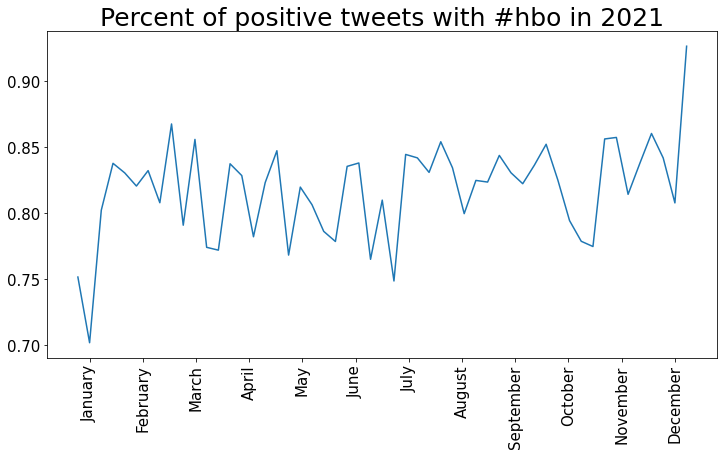

In [31]:
a = [x/(x + y) for (x, y) in zip(hbo_year_pos, hbo_year_neg)]
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(a)
ax.set_xticks(np.linspace(1, len(hbo_year_pos)-2, 12))
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Percent of positive tweets with #hbo in 2021', fontdict={'fontsize': 25})
plt.show()